In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, diags, eye, block_diag, bmat
from scipy.sparse.linalg import norm

try:
    from ipypb import track
except ImportError:
    from tqdm.auto import tqdm as track

from dataprep import split_holdout, sample_unseen_interactions
from utils import topk_idx

In [2]:
# randomization control
seed = 0
holdout_seed = 42 # to sample unseen items for holdout
# evaluation setitings
target_metric = 'hr'

# Data

In [3]:
full_data = pd.read_csv('./data/raw/yahoo_data_full.gz')
full_data.head(5)

,userid,itemid,is_holdout
0,346,1,False
1,385,1,False
2,517,1,False
3,538,1,False
4,651,1,False


In [4]:
rs = np.random.RandomState(seed)

train, holdout = split_holdout(  # test
    full_data,
    sample_max_rated = True,
    feedback = 'is_holdout',
    random_state = rs
)

In [5]:
assert not train.is_holdout.any()
assert holdout.is_holdout.all()

In [6]:
holdout_unseen = sample_unseen_interactions(
    full_data,
    train.itemid.unique(), 
    seed=holdout_seed)
holdout_unseen.head()

userid
346    [146, 895, 303, 1293, 624, 1287, 623, 436, 327...
385    [2180, 1352, 502, 2802, 978, 2530, 3149, 999, ...
517    [946, 416, 3254, 2866, 3030, 3256, 1902, 2226,...
538    [1305, 2289, 1916, 2807, 2576, 2778, 1977, 753...
651    [8, 2669, 2827, 2558, 3114, 2320, 428, 1155, 1...
Name: itemid, dtype: object

## Use sparse format

In [7]:
# encode users and items to [0, N] interval with no missing indices
useridx, all_users = pd.factorize(train.userid)
itemidx, all_items = pd.factorize(train.itemid)

In [8]:
rating_matrix = csr_matrix( # for efficient storage and some computations
    (
        np.ones(train.shape[0], dtype='f8'),
        (useridx, itemidx)
    )
)
rating_matrix

<7307x3312 sparse matrix of type '<class 'numpy.float64'>'
	with 397438 stored elements in Compressed Sparse Row format>

In [9]:
print(
    "Users: {};\nItems: {};\nNNZ entries: {};\nDensity: {:%}"
    .format(
        *rating_matrix.shape,
        rating_matrix.nnz,
        rating_matrix.nnz / np.prod(rating_matrix.shape)
    )
)

Users: 7307;
Items: 3312;
NNZ entries: 397438;
Density: 1.642253%


## Reindex datasets

In [10]:
unseen_samples = np.array([
    [all_items.get_loc(i) for i in x]
    for x in holdout_unseen.loc[all_users]
])

holdout_items = (
    holdout
    .set_index('userid')
    .loc[all_users, 'itemid']
    .map(all_items.get_loc)
    .values
)

# Model

## SLIM

```python
from SLIM import SLIM, SLIMatrix
#Parameters on NN:
n_items = rating_matrix.shape[1]
C = int(n_items * 0.1)
 #Train Matrix W:
trainmat = SLIMatrix(rating_matrix)
params = {'algo':'cd',
          'nthreads': 4,
          'l1r': 10,
          'l2r': 10,
          'nnbrs': C
         }
model = SLIM()
model.train(params, trainmat)
#Got Matrix W:
WSlim = model.to_csr()
np.savez_compressed(
    'W_model_SLIM',
    indices = WSlim.indices,
    indptr = WSlim.indptr,
    data = WSlim.data,
    item_index = all_items
)
```

In [11]:
WSlim_data = np.load('W_model_SLIM.npz')
WSlim = csr_matrix(
    (WSlim_data['data'], WSlim_data['indices'], WSlim_data['indptr']),
    shape = (len(WSlim_data['item_index']),)*2
)
assert np.testing.assert_array_equal(all_items, WSlim_data['item_index'])

WSlim

<3312x3312 sparse matrix of type '<class 'numpy.float32'>'
	with 50538 stored elements in Compressed Sparse Row format>

In [12]:
#Density of distance matrix W, diagonal and other elements
print(f"Density of W: {WSlim.nnz / np.prod(WSlim.shape):%}")
print(f"Number of elements less than 0 in W: {(WSlim.data<0).sum()}")
print(f"Maximal diagonal element of the W:   {WSlim.diagonal().max()}")

Density of W: 0.460720%
Number of elements less than 0 in W: 0
Maximal diagonal element of the W:   0.0


## RecWalk

In [13]:
#Make P matrix that our final recommendation model
def rec_walk_model(item_model, rating_matrix, alpha=0.005):
    inter_item = item_model / norm(item_model, np.inf)
    adjustment = 1 - inter_item.sum(axis=1).A.squeeze() # stochasticity adjustment
    inter_item += diags(adjustment, shape=item_model.shape, format='csr')

    transition = block_diag( # M matrix
        (eye(rating_matrix.shape[0], format='csr'), inter_item),
        format = 'csr',
        dtype = 'float64'
    )
    walk_model = bmat( # H matrix
        [[None, rating_matrix], [rating_matrix.T, None]],
        format = 'csr',
        dtype = 'float64'
    )
    k = np.reciprocal(walk_model.sum(axis=1).A.squeeze())
    walk_model = diags(k, format='csr').dot(walk_model)
    return alpha * walk_model + (1-alpha) * transition

In [14]:
#RecWalk P matrix with W SLIM based:
transition_matrix = rec_walk_model(WSlim, rating_matrix)

In [15]:
print(f"Density of P: {transition_matrix.nnz/np.prod(transition_matrix.shape):%}")

Density of P: 0.759142%


# Evaluation

In [16]:
def evaluate(scores, holdout_items, holdout_unseen, topk=10):
    rows = np.arange(len(holdout_items))
    holdout_scores = scores[rows, holdout_items]
    random_scores = scores[
        np.broadcast_to(rows[:, None], holdout_unseen.shape),
        holdout_unseen
    ]
    
    test_scores = np.concatenate((holdout_scores[:, None], random_scores), axis=1)
    top_recs = np.apply_along_axis(topk_idx, 1, test_scores, topk)        
    _, rec_pos = np.where(top_recs == 0) # holdout has index 0 by construction
    
    hr = len(rec_pos) / len(holdout_items)
    arhr = np.reciprocal(rec_pos + 1.).sum() / len(holdout_items)
    return hr, arhr

In [17]:
# Make a few more steps to future to capture intersactions between items:
K = 20

n_users = rating_matrix.shape[0]
k_step_matrix = transition_matrix[:n_users, :].toarray()
transition_matrix = transition_matrix.tocsc()

metrics = []
for k in track(range(K)): 
    k_step_matrix = transition_matrix.T.dot(k_step_matrix.T).T
    prediction_matrix = k_step_matrix[:, n_users:]
    metrics.append(
        evaluate(prediction_matrix, holdout_items, unseen_samples)
    )

 [████████████████████████████████████████████████████████████] 20/20 [01:42<00:05, 5.08s/it]

In [18]:
metrics[3] # k = 5 -> 3 elem.

(0.546188586287122, 0.28086836714522495)

Best result: HR@10 = 0.5462;  
k = 5; y1 = 10; y2 = 10; C = 331; alpha = 0.005;

Best result: ARHR@10 = 0.2809;  
k = 5; y1 = 10; y2 = 10; C = 331; alpha = 0.005;

## Plot results

In [19]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [20]:
hr, arhr = zip(*metrics)

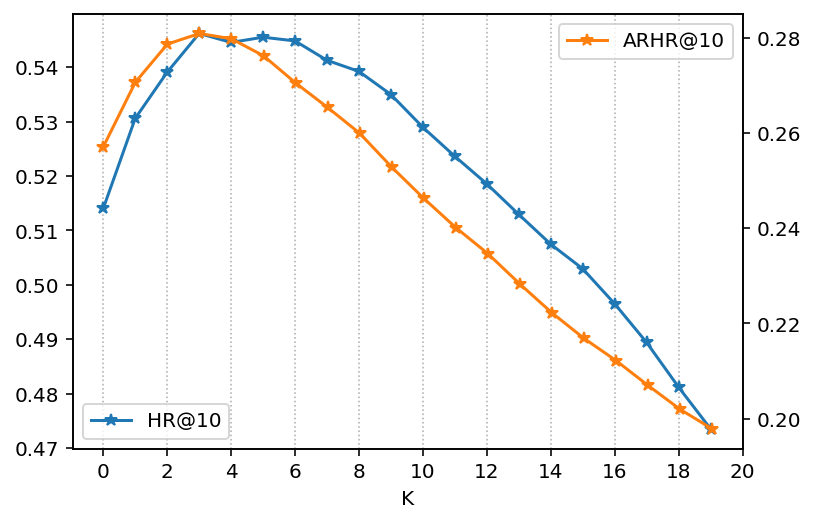

In [21]:
ax1 = pd.Series(hr).plot(linestyle='-', marker='*', label='HR@10')
ax2 = pd.Series(arhr).plot(secondary_y=True, linestyle='-', marker='*', label='ARHR@10')

ax1.set_xlabel('K')
ax1.xaxis.grid(True, linestyle=':')
ax1.set_xticks(range(0, 22, 2))
ax1.legend(loc=3)

ax2.legend(loc=0);